In [2]:
# !pip install pandas numpy matplotlib openpyxl

In [3]:
import pandas as pd
from io import BytesIO
import math
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import importlib


In [4]:
# path to the excel file
path = "TurboPi_Actuation_tests.xlsx"

# pattern matching for sheet names
RE_TURNING_SHEET = re.compile(r'Robot\s*\d+\s*', flags=re.IGNORECASE)
RE_STRAIGHT_SHEET = re.compile(r'Robot\s*\d+\s?-\s?No Turning\s*', flags=re.IGNORECASE)

# constants used to calculate speeds and turning rates
NTURNS = 5
ROBOT_DIAMETER = 0.16

# column names
VF = 'Forward Speed'
DN = 'Direction'
TR = 'Turning-Rate'
D1 = 'Diameter of Measured Circle (D1) (m)'
TT = 'Time to 5 Turns (sec)'
VD = '"Vertical" Distance (m)'
HD = '"Horizontal" Distance (m)'
VT = 'Time (sec)'

# read the excel file
with open(path, 'rb') as f:
    xlsx = f.read()
xlsx = pd.ExcelFile(BytesIO(xlsx))

# read the turning and straight sheets
turning_sheet_names = [sheet for sheet in xlsx.sheet_names if RE_TURNING_SHEET.fullmatch(sheet)]
turning_dataframes = {sheet: pd.read_excel(xlsx, sheet_name=sheet, usecols='A:C,E,F', skiprows=1) for sheet in turning_sheet_names}
straight_sheet_names = [sheet for sheet in xlsx.sheet_names if RE_STRAIGHT_SHEET.fullmatch(sheet)]
straight_dataframes = {sheet: pd.read_excel(xlsx, sheet_name=sheet, usecols='A:C,E,F,G', skiprows=1) for sheet in straight_sheet_names}

### processing turning data

In [5]:
turning_data = []
for sheet in turning_sheet_names:
    df = turning_dataframes[sheet]

    # ignore cells with errors/text
    for col in [VF, DN, TR]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].ffill()  # forward fill missing values to take care of merged cells
    for col in [D1, TT]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # conditions
    c1 = df[DN] == 90.0  # only use data from forward movements
    c2 = df[TT].isna()
    c3 = df[D1].isna()
    mask = ~pd.DataFrame([c2, c3, c2 & c3], ['c2', 'c3', 'both']).T
    # ignore rows where both speed and diameter measurements are missing
    df = df[c1 & mask.both]

    turning_data.append(df)

# stack the data from the different robots
df = pd.concat(turning_data, axis='rows')

# calculate speed and angular velocity
speed = NTURNS * (df[D1] - ROBOT_DIAMETER) * math.pi / df[TT]
speed = speed.fillna(0)
radss = NTURNS * 2 * math.pi / df[TT]
radss = radss.fillna(0)

# add columns to dataframe
df = df.assign(Speed=speed, Angular_Velocity=radss)

# assign new variable name and show
(dft := df)

,Forward Speed,Direction,Turning-Rate,Time to 5 Turns (sec),Diameter of Measured Circle (D1) (m),Speed,Angular_Velocity
0,100.0,90.0,2.0,12.38,NaN,0.0,2.537635
1,100.0,90.0,2.0,12.73,NaN,0.0,2.467865
2,100.0,90.0,2.0,12.58,NaN,0.0,2.497291
3,100.0,90.0,1.5,13.13,NaN,0.0,2.392683
4,100.0,90.0,1.5,13.20,NaN,0.0,2.379994
...,...,...,...,...,...,...,...
43,50.0,90.0,-1.5,11.98,NaN,0.0,2.622364
44,50.0,90.0,-1.5,11.98,NaN,0.0,2.622364
45,50.0,90.0,-2.0,11.94,NaN,0.0,2.631150
46,50.0,90.0,-2.0,12.44,NaN,0.0,2.525396


### processing no turning data

In [6]:
straight_data = []
for sheet in straight_sheet_names:
    df = straight_dataframes[sheet]

    # ignore cells with errors/text
    for col in [VF, DN, TR]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].ffill()  # forward fill missing values to take care of merged cells
    for col in [VD, HD, VT]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # conditions
    c1 = (df[DN] == 90.0) | (df[DN] == 270.0)  # only use data from forward movements
    c2 = df[VD].notna()
    c3 = df[HD].notna()
    c4 = df[VT].notna()
    # require that all three measurements are present
    df = df[c1 & c2 & c3 & c4]

    straight_data.append(df)

# stack the data from the different robots
df = pd.concat(straight_data, axis='rows')

# calculate speed
speed = np.linalg.norm(df[[VD, HD]].values, axis=1) / df[VT]
speed = speed.fillna(0)  # fill nan with 0

df = df.assign(Speed=speed)  # add speed column

# assign new variable name and show
(dfs := df)

,Forward Speed,Direction,Turning-Rate,"""Vertical"" Distance (m)","""Horizontal"" Distance (m)",Time (sec),Speed
12,100.0,90.0,0.0,1.79,0.140,5.0,0.359093
13,100.0,90.0,0.0,1.82,0.100,5.0,0.364549
14,100.0,90.0,0.0,1.82,0.010,5.0,0.364005
15,50.0,90.0,0.0,1.41,0.130,5.0,0.283196
16,50.0,90.0,0.0,1.38,0.190,5.0,0.278604
17,50.0,90.0,0.0,1.36,0.220,5.0,0.275536
36,100.0,270.0,0.0,1.64,0.320,5.0,0.334186
12,100.0,90.0,0.0,1.78,0.140,5.0,0.357099
13,100.0,90.0,0.0,1.83,0.000,5.0,0.366000
14,100.0,90.0,0.0,1.78,0.160,5.0,0.357435


### combining all the data

In [7]:
# merge the dataframes

# copy missing columns
for col in dft.columns:
    if col not in dfs.columns:
        dfs[col] = float('nan')

for col in dfs.columns:
    if col not in dft.columns:
        dft[col] = float('nan')

# show only the columns we want
cols = [VF, DN, TR, 'Speed', 'Angular_Velocity']
# need to reset the index to prevent duplicates (i.e. row 1 exists in both dfs and dft)
df1 = dfs[cols].reset_index(drop=True)
df2 = dft[cols].reset_index(drop=True)
df2.index += df1.index.stop

# merge the dataframes
data = pd.concat([df1, df2], axis='rows')
data.fillna(0, inplace=True)
data

,Forward Speed,Direction,Turning-Rate,Speed,Angular_Velocity
0,100.0,90.0,0.0,0.359093,0.000000
1,100.0,90.0,0.0,0.364549,0.000000
2,100.0,90.0,0.0,0.364005,0.000000
3,50.0,90.0,0.0,0.283196,0.000000
4,50.0,90.0,0.0,0.278604,0.000000
...,...,...,...,...,...
371,50.0,90.0,-1.5,0.000000,2.622364
372,50.0,90.0,-1.5,0.000000,2.622364
373,50.0,90.0,-2.0,0.000000,2.631150
374,50.0,90.0,-2.0,0.000000,2.525396


## Visualizing the entire dataset

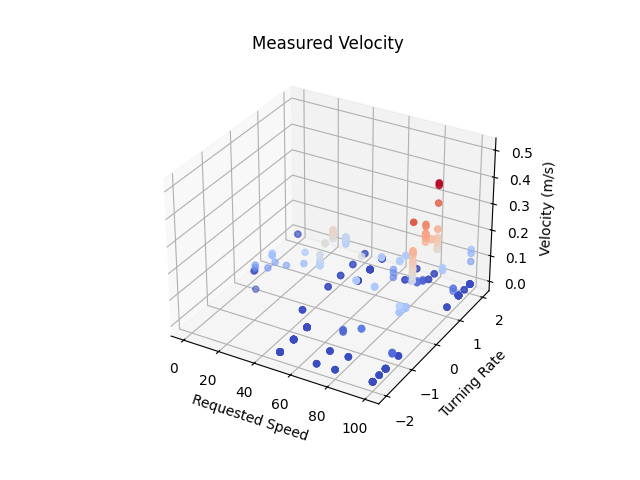

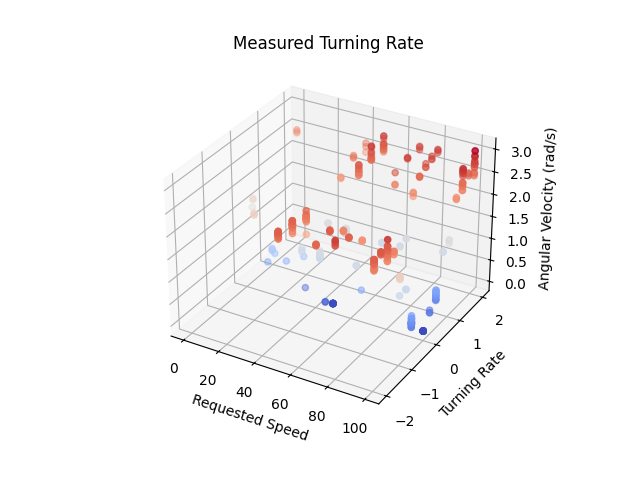

In [27]:

if importlib.util.find_spec("ipympl"):
    %matplotlib widget
else:
    print("no ipympl")

Z = [data['Speed'], data['Angular_Velocity']]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(data[VF], data[TR], Z, vmin=Z.min() * 2, cmap=cm.Blues)
ax.scatter(data[VF], data[TR], Z[0], c=Z[0], cmap=cm.coolwarm)
ax.set_title("Measured Velocity")
ax.set_xlabel('Requested Speed')
ax.set_ylabel('Turning Rate')
ax.set_zlabel('Velocity (m/s)')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title("Measured Turning Rate")
ax.set_xlabel('Requested Speed')
ax.set_ylabel('Turning Rate')
ax.set_zlabel('Angular Velocity (rad/s)')
ax.scatter(data[VF], data[TR], Z[1], c=Z[1], cmap=cm.coolwarm)
# plt.show()

### kernel-based regression

In [9]:
# symmetrize data
symdf = data.copy()
symdf[VF] = np.abs(symdf[VF])
symdf[TR] = np.abs(symdf[TR])
symdf['Speed'] = np.abs(symdf['Speed'])
symdf['Angular_Velocity'] = np.abs(symdf['Angular_Velocity'])

rng = np.random.RandomState(42)

X = symdf[[VF, TR]]
y_v = symdf['Speed']
y_w = symdf['Angular_Velocity']

# Add noise to targets
# y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

In [10]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [11]:
train_size = 362

# w_predict = SVR(kernel="rbf", gamma='scale', C=10)
# v_predict = KernelRidge(kernel="rbf", gamma=0.1, alpha=0.005)
v_predict = KernelRidge(kernel="polynomial", degree=6, gamma=0.01, alpha=0.005)
w_predict = KernelRidge(kernel="polynomial", degree=3, gamma=0.005, alpha=0.001)
t0 = time.time()
v_predict.fit(X[:train_size], y_v[:train_size])
w_predict.fit(X[:train_size], y_w[:train_size])
svr_fit = time.time() - t0

c:\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [12]:
v_predict.score(X[:train_size], y_v[:train_size])

0.9041690915115453

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KernelRidge was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Speed (m/s)')

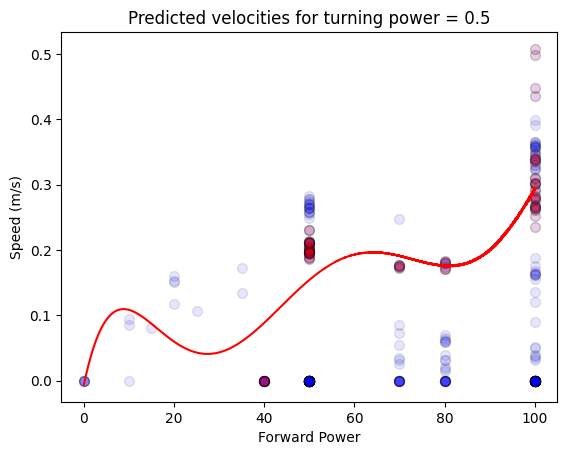

In [13]:
tr = 0.5
x_test = np.linspace([0, tr], [100, tr], 10000)
y_test = v_predict.predict(x_test)

matches = X[TR] == tr

plt.scatter(
    X[VF],
    y_v,
    c="b",
    s=50,
    label="all velocity data",
    zorder=2,
    edgecolors=(0, 0, 0),
    alpha=0.1,
)
plt.scatter(
    X[VF][matches],
    y_v[matches],
    c="r",
    s=50,
    label="all velocity data",
    zorder=2,
    edgecolors=(0, 0, 0),
    alpha=0.1,
)
plt.plot(
    x_test[:, 0],
    y_test,
    c="r",
    # label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict),
)

plt.title(f"Predicted velocities for turning power = {tr}")
plt.xlabel("Forward Power")
plt.ylabel("Speed (m/s)")

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KernelRidge was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Angular Velocity (rad/s)')

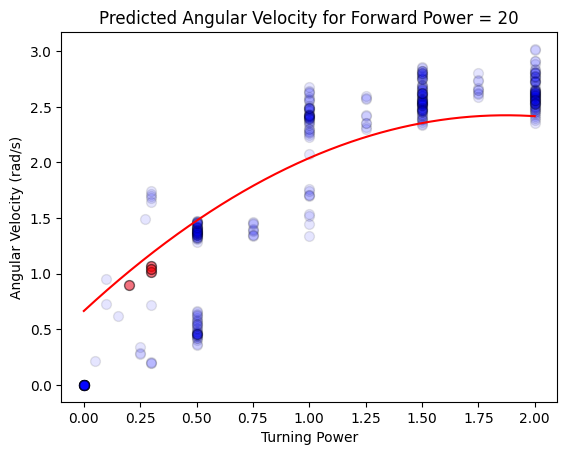

In [14]:
fp = 20
x_test = np.linspace([fp, 0], [fp, 2.0], 500)
y_test = w_predict.predict(x_test)

matches = X[VF] == fp

plt.scatter(
    X[TR],
    y_w,
    c="b",
    s=50,
    # label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0),
    alpha=0.1,
)
plt.scatter(
    X[TR][matches],
    y_w[matches],
    c="r",
    s=50,
    # label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0),
    alpha=0.5,
)
plt.plot(
    x_test[:, 1],
    y_test,
    c="r",
    # label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict),
)

plt.title(f"Predicted Angular Velocity for Forward Power = {fp}")
plt.xlabel("Turning Power")
plt.ylabel("Angular Velocity (rad/s)")